# Calculate Nino 3.4 Time Series using CMIP5 ACCESS-1.3 model

In this notebook we calculate the Nino 3.4 index for the ACCESS-1.3 CMIP5 submission using the sea surface temperature from the ocean model component.

* Load data
* Calculate a monthly climatology of mean SST for the 1950-1979 period
* Compare the values of climatological mean SST with those from the classic Trenberth paper
* Calculate the Nino 3.4 index
* Moving average smoother
* Data normalisation
* A bit play with time series plotting

This example uses Coupled Model Intercomparison Project (CMIP5) collections. For more information, please visit [data catalogue](https://geonetwork.nci.org.au/geonetwork/srv/eng/catalog.search#/metadata/f3525_9322_8600_7716) and [terms of use](https://cmip.llnl.gov/cmip5/terms.html).

---------

- Authors: NCI Virtual Research Environment Team
- Keywords: CMIP, xarray, ACCESS, Nino34 Index
- Create Date: 2020-Apr
- Lineage/Reference: This example was modified from the original example developed by Dr Aidan Heerdegen from ARC COE Clex group
---

## Nino 3.4 index 

The definition of Nino 3.4 index can be found [here](https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni).

> Niño 3.4 (5N-5S, 170W-120W):  The  Niño 3.4 anomalies may be thought of as representing the average equatorial SSTs across the Pacific from about the dateline to the South American coast.  The Niño 3.4 index typically uses a 5-month running mean, and El Niño or La  Niña events are defined when the  Niño 3.4 SSTs exceed +/- 0.4C for a period of six months or more.

> Nino X Index computation: (a) Compute area averaged total SST from Niño X region; (b) Compute monthly climatology (e.g., 1950-1979) for area averaged total SST from Niño X region, and subtract climatology from area averaged total SST time series to obtain anomalies; (c) Smooth the anomalies with a 5-month running mean; (d) Normalize the smoothed values by its standard deviation over the climatological period.

#### Import the xarray and netCDF modules

In [1]:
import xarray as xr
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Open data

The first step is to open the dataset either via URL or directly on the file system.

Note, the URL for the relevant dataset is below if you run this examples on your local computer.

http://dapds00.nci.org.au/thredds/dodsC/rr3/CMIP5/output1/CSIRO-BOM/ACCESS1-3/historical/mon/ocean/Omon/r1i1p1/latest/tos/tos_Omon_ACCESS1-3_historical_r1i1p1_185001-200512.nc

First step is to open the dataset either via URL or directly on the file system.

In [2]:
CMIP5_data = '/g/data/rr3/publications/CMIP5/output1/CSIRO-BOM/ACCESS1-3/historical/mon/ocean/Omon/r1i1p1/latest/tos/tos_Omon_ACCESS1-3_historical_r1i1p1_185001-200512.nc'
ds = xr.open_dataset(CMIP5_data)
ds

<xarray.Dataset>
Dimensions:       (bnds: 2, i: 360, j: 300, time: 1872, vertices: 4)
Coordinates:
  * time          (time) datetime64[ns] 1850-01-16T12:00:00 ... 2005-12-16T12...
  * j             (j) int32 0 1 2 3 4 5 6 7 ... 292 293 294 295 296 297 298 299
  * i             (i) int32 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
    lat           (j, i) float32 ...
    lon           (j, i) float32 ...
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds     (time, bnds) datetime64[ns] ...
    lat_vertices  (j, i, vertices) float32 ...
    lon_vertices  (j, i, vertices) float32 ...
    tos           (time, j, i) float32 ...
Attributes:
    institution:            CSIRO (Commonwealth Scientific and Industrial Res...
    institute_id:           CSIRO-BOM
    experiment_id:          historical
    source:                 ACCESS1-3 2011. Atmosphere: AGCM v1.0 (N96 grid-p...
    model_id:               ACCESS1.3
    forcing:                GHG, Oz, SA, Sl, Vl, BC, OC, (GHG = CO2, N2O, CH4...
    parent_experiment_id:   piControl
    parent_experiment_rip:  r1i1p1
    branch_time:            90945.0
    contact:                The ACCESS wiki: http://wiki.csiro.au/confluence/...
    history:                CMIP5 compliant file produced from raw ACCESS mod...
    references:             See http://wiki.csiro.au/confluence/display/ACCES...
    initialization_method:  1
    physics_version:        1
    tracking_id:            133724da-4e35-4a17-811a-36891ab0d95d
    version_number:         v20120413
    product:                output
    experiment:             historical
    frequency:              mon
    creation_date:          2012-02-06T01:20:17Z
    Conventions:            CF-1.4
    project_id:             CMIP5
    table_id:               Table Omon (27 April 2011) 694b38a3f68f18e58ba802...
    title:                  ACCESS1-3 model output prepared for CMIP5 historical
    parent_experiment:      pre-industrial control
    modeling_realm:         ocean
    realization:            1
    cmor_version:           2.8.0

Find the sea surface temperature (SST) variable name and create a new variable which selects out all data after 1950. Probably a good idea to plot the first time slice as a reference

In [3]:
tos = ds.tos.sel(time=slice('1950',None))
tos

<xarray.DataArray 'tos' (time: 672, j: 300, i: 360)>
[72576000 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1950-01-16T12:00:00 ... 2005-12-16T12:00:00
  * j        (j) int32 0 1 2 3 4 5 6 7 8 ... 291 292 293 294 295 296 297 298 299
  * i        (i) int32 0 1 2 3 4 5 6 7 8 ... 351 352 353 354 355 356 357 358 359
    lat      (j, i) float32 ...
    lon      (j, i) float32 ...
Attributes:
    standard_name:     sea_surface_temperature
    long_name:         Sea Surface Temperature
    comment:           "this may differ from ""surface temperature"" in regio...
    units:             K
    cell_methods:      time: mean
    cell_measures:     area: areacello
    history:           2012-02-06T01:20:16Z altered by CMOR: replaced missing...
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...

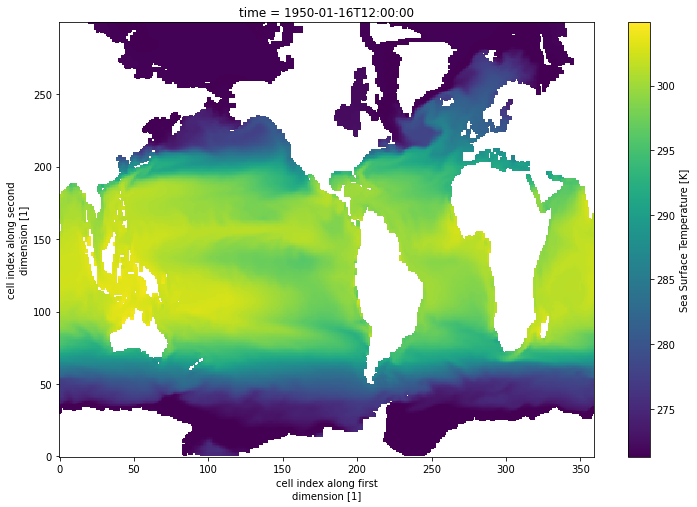

In [4]:
tos.isel(time=0).plot(size=8)

MOM5 is the ocean model component of ACCESS-1.3. In this configuration the ocean has a tripolar grid. This means there are three poles, to avoid having a convergent point in the ocean. All three poles are over land points where there are no wet cells. One pole in the south over Antarctica and two in the north. What this means is that the data have coordinates `i` and `j` and the `lat` and `lon` data variables are 2D and also have coordinates `i` and `j`. The tripolar grid only starts diverging from a normal grid above 60N, so does not affect the calculation of Nino 3.4, but it does make it more difficult to select out the area of interest.

![Tripole Grid](images/tripole.png)

There are a few ways selecting out the region of interest (ROI). 

1. Find the cell indices for the ROI and use `sel`
2. Chop off the tripolar part of the grid and add new 1D lat/lon coordinates to the dataset/variable
3. Use `where` and select for all values within the bounds of interest.

It is the last option that is easiest, for variable `var` it is formulated like so

`var.where((var.lat<5) & (var.lat>-5) & (var.lon>190) & (var.lon<240),drop=True)`

note the `drop=True` option, which will remove all masked cells, which in this case is equivalent to a `sel` operation using `slice` on `lat` and `lon`

In [5]:
tos_nino34 = tos.where((tos.lat<5) & (tos.lat>-5) & (tos.lon>190) & (tos.lon<240), drop=True)

In [6]:
tos_nino34

<xarray.DataArray 'tos' (time: 672, j: 30, i: 50)>
array([[[300.94846, 300.88568, 300.87427, ..., 297.64374, 297.60992,
         297.57465],
        [300.62796, 300.58807, 300.57635, ..., 297.52548, 297.4986 ,
         297.47824],
        [300.39053, 300.37262, 300.36188, ..., 297.4185 , 297.39447,
         297.38327],
        ...,
        [299.3151 , 299.3223 , 299.34775, ..., 300.94946, 301.0162 ,
         301.0617 ],
        [299.68683, 299.54962, 299.48615, ..., 301.0525 , 301.09686,
         301.13242],
        [300.4037 , 300.18784, 300.00842, ..., 301.085  , 301.11496,
         301.1423 ]],

       [[300.71313, 300.59174, 300.46158, ..., 298.60413, 298.63116,
         298.65945],
        [300.49048, 300.41953, 300.31433, ..., 298.59286, 298.61975,
         298.65106],
        [300.33057, 300.25937, 300.114  , ..., 298.5928 , 298.6208 ,
         298.6491 ],
...
        [302.4275 , 302.40497, 302.36984, ..., 301.34897, 301.28528,
         301.2992 ],
        [302.6383 , 302.61084, 302.57703, ..., 301.67218, 301.62723,
         301.63782],
        [302.8222 , 302.80893, 302.79022, ..., 301.89783, 301.8747 ,
         301.88324]],

       [[302.58627, 302.5506 , 302.47406, ..., 298.7326 , 298.61194,
         298.5167 ],
        [302.33844, 302.2614 , 302.17407, ..., 298.54724, 298.43848,
         298.3609 ],
        [302.06375, 301.96933, 301.87567, ..., 298.401  , 298.3131 ,
         298.25192],
        ...,
        [301.78677, 301.74954, 301.69775, ..., 301.62314, 301.60974,
         301.50467],
        [301.98654, 301.98233, 301.97385, ..., 301.88876, 301.89926,
         301.84207],
        [302.10608, 302.11246, 302.12888, ..., 302.04364, 302.05737,
         302.03275]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1950-01-16T12:00:00 ... 2005-12-16T12:00:00
  * j        (j) int32 122 123 124 125 126 127 128 ... 146 147 148 149 150 151
  * i        (i) int32 110 111 112 113 114 115 116 ... 154 155 156 157 158 159
    lat      (j, i) float32 -4.8328757 -4.8328757 ... 4.8328757 4.8328757
    lon      (j, i) float32 190.5 191.5 192.5 193.5 ... 236.5 237.5 238.5 239.5
Attributes:
    standard_name:     sea_surface_temperature
    long_name:         Sea Surface Temperature
    comment:           "this may differ from ""surface temperature"" in regio...
    units:             K
    cell_methods:      time: mean
    cell_measures:     area: areacello
    history:           2012-02-06T01:20:16Z altered by CMOR: replaced missing...
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...

In [7]:
print('Check we have the correct spatial extent')
print('Latitude range: {:.1f} - {:.1f}'.format(tos_nino34.lat.min().values, tos_nino34.lat.max().values))
print('Longitude range: {:.1f} - {:.1f}'.format(tos_nino34.lon.min().values, tos_nino34.lon.max().values))

Check we have the correct spatial extent
Latitude range: -4.8 - 4.8
Longitude range: 190.5 - 239.5


Calculate a monthly climatology of mean SST for the 1950-1979 period. Note this should be a single value for each month

In [8]:
tos_nino34_climatology = tos_nino34.sel(time=slice('1950','1979')).groupby('time.month').mean()

Compare the values of climatological mean SST with those from the [classic Trenberth paper](https://doi.org/10.1175/1520-0477(1997)078%3C2771:TDOENO%3E2.0.CO;2)

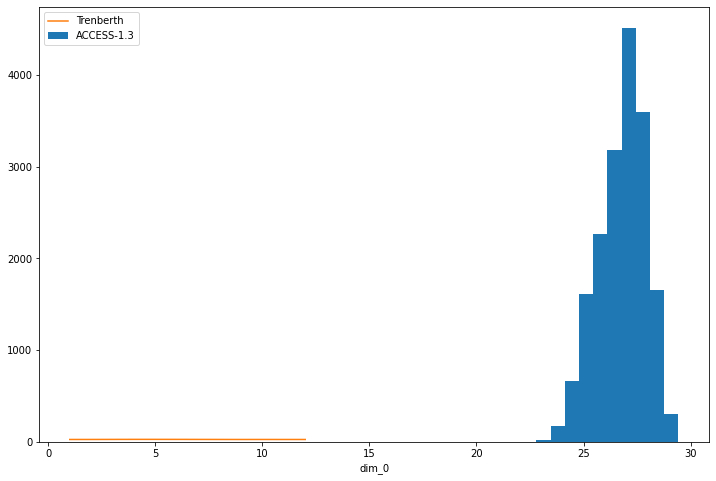

In [9]:
(tos_nino34_climatology - 273).plot(size=8,label='ACCESS-1.3')
mean_sst_trenberth = xr.DataArray([26.4, 26.6, 27.1, 27.6, 27.5, 27.4, 27.0, 26.7, 26.4, 26.5, 26.4, 26.4], coords=[np.arange(12)+1])
mean_sst_trenberth.plot(label="Trenberth")
plt.legend()

Now calculate the Nino 3.4 index by subtracting the monthly climatology from the original SST data and take the mean over the spatial coordinates (the monthly anomaly of SST over the Nino3.4 region).

In [10]:
index_nino34 = (tos_nino34.groupby('time.month')-tos_nino34_climatology).mean(dim=['j','i'])

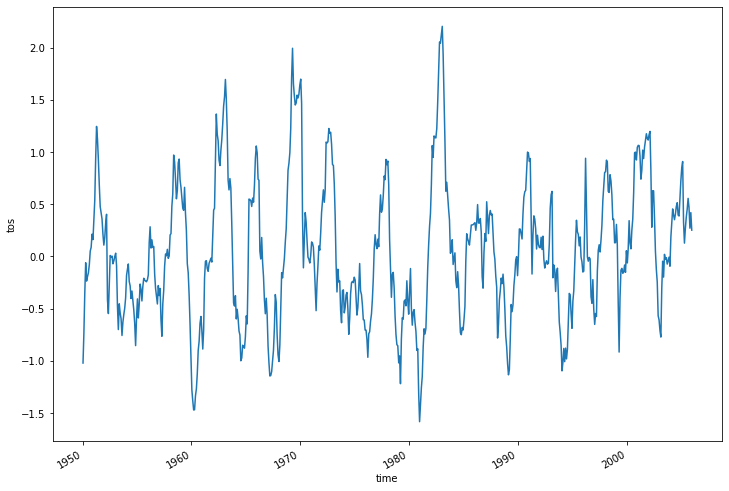

In [11]:
index_nino34.plot(size=8)

Next step is to apply a 5-month moving average smoother. xarray has a method [rolling](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.rolling.html) which can be applied to the your saved variable and then directly plotted

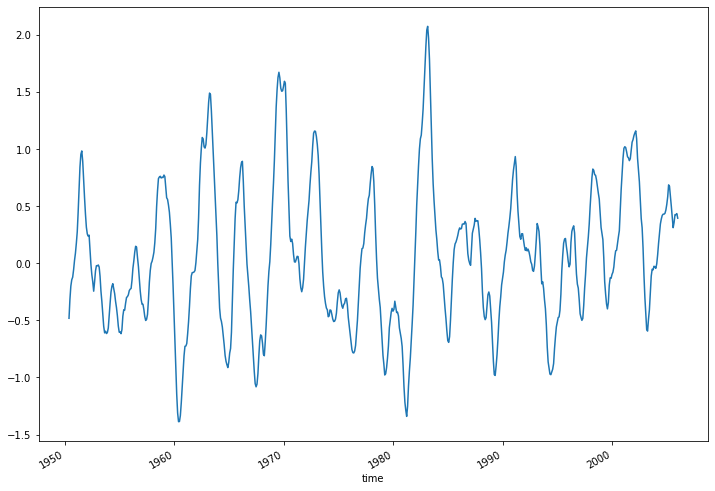

In [12]:
index_nino34.rolling(time=5).mean().plot(size=8)

Last step is to normalise by the standard deviation. Calculate the standard deviation of the SST data in the Nino 3.4 area for the climatological period. xarray provides the [std](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.std.html?highlight=std) operator for this purpose. Save the result in a new variable. Note that this is an average over the entire climatological period, so should be a single value

In [13]:
tas_nino34_climatology_std = tos_nino34.sel(time=slice('1950-01','1979-12')).std()

As the standard deviation is a single value it is sufficient to use the same formulation for your plot as above but divide by the standard deviation and then plot the result. Note that parentheses will be required around the divide operation to correctly chain the `plot()` operator. e.g. something like

`(index_variable.rolling().mean() / std_dev).plot()`

Alternatively, you could save the normalised value into a new variable and then plot that

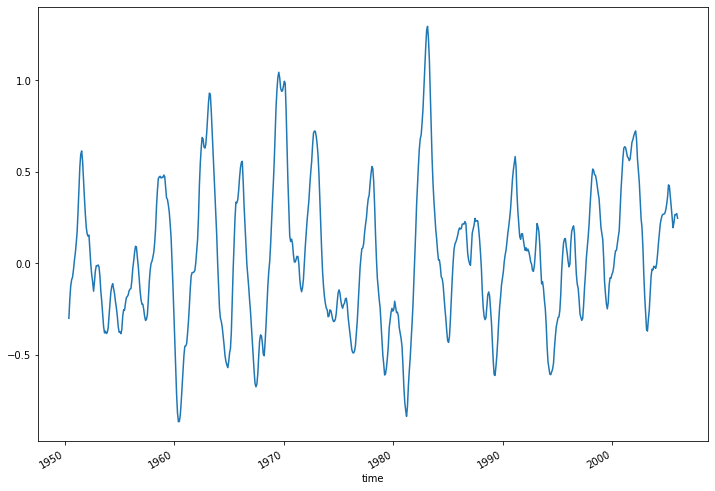

In [14]:
(index_nino34.rolling(time=5).mean() / tas_nino34_climatology_std).plot(size=8)

Add some -0.4/+0.4 lines which are the El Niño threshold

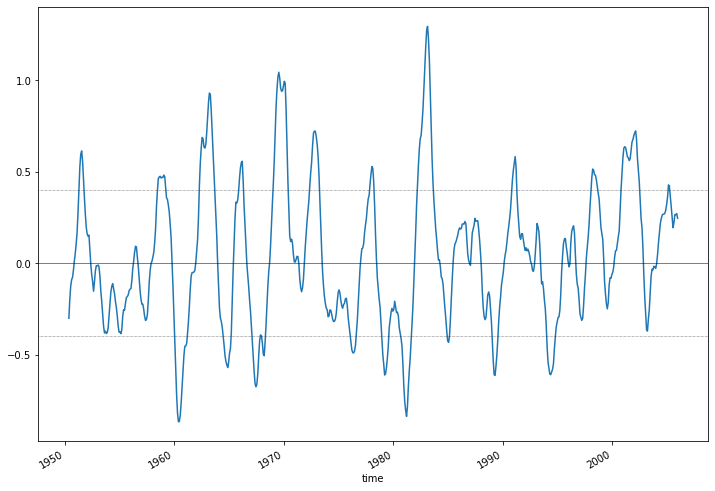

In [15]:
(index_nino34.rolling(time=5).mean() / tas_nino34_climatology_std).plot(size=8)
plt.axhline(0,color='black',lw=0.5)
plt.axhline(0.4,color='black',linewidth=0.5,linestyle='dotted')
plt.axhline(-0.4,color='black',linewidth=0.5,linestyle='dotted')

As an extension, we will re-create the figure from Trenberth

![Trenberth Grid](images/Trenberth.png)

Assign the final Nino 3.4 normalised and smoothed index to a temporary variable for convenience

In [16]:
tmp = (index_nino34.rolling(time=5).mean() / tas_nino34_climatology_std)

To recreate the Nino 3.4 plot from Trenberth requires using the matplotlib function [fill_between](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.fill_between.html) directly. It is called twice, once for the El Nino events, and then again for La Nina. Masking is used to select only values above, or below, a certain threshold, and the same threshold is then used as an argument to `fill_between` to set the other limit of the fill colour.

Text(0.5, 1.0, 'Nino 3.4 Region (Threshold = 0.4 $\\degree$C)')

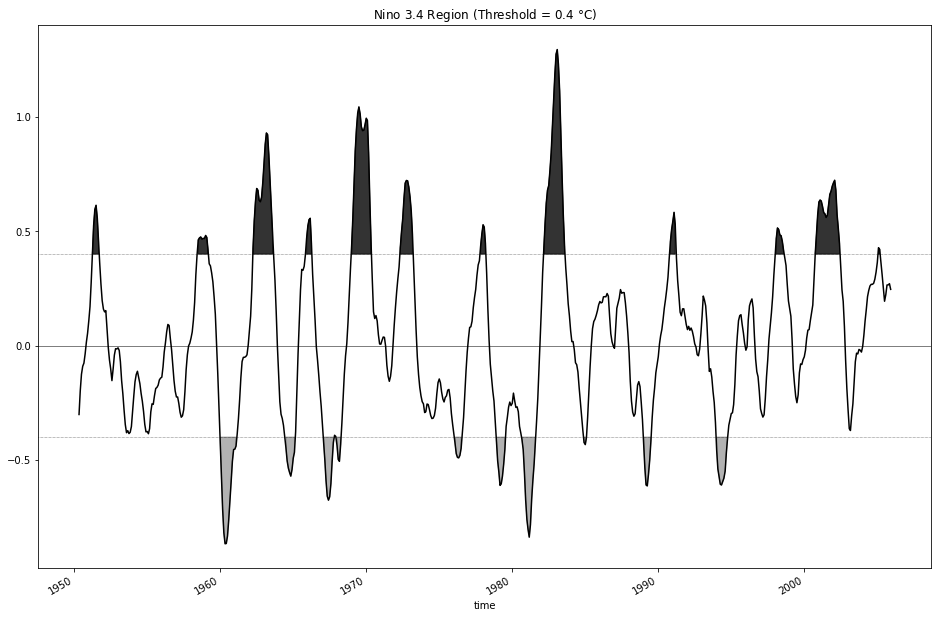

In [17]:
fig = plt.figure(figsize=(16, 10))
plt.fill_between(tmp.time.values, tmp.where(tmp>=0.4).values, 0.4, color='black', alpha=0.8)
plt.fill_between(tmp.time.values, tmp.where(tmp<=-0.4).values, -0.4, color='black', alpha=0.3)
# plt.fill_between(tmp.time.values, tmp.where(tmp<0.4,0.4).where(tmp>-0.4,-0.4).values, color='white')
tmp.plot(color='black')
plt.axhline(0,color='black',lw=0.5)
plt.axhline(0.4,color='black',linewidth=0.5,linestyle='dotted')
plt.axhline(-0.4,color='black',linewidth=0.5,linestyle='dotted')
plt.title('Nino 3.4 Region (Threshold = 0.4 $\degree$C)')

In [18]:
"Percentage of El Nino events = {:0.1f}%".format(100 * (tmp.where(tmp>=0.4).count() / tmp.count()).values)

'Percentage of El Nino events = 18.4%'

In [19]:
"Percentage of La Nina events = {:0.1f}%".format(100 * (tmp.where(tmp<=-0.4).count() / tmp.count()).values)

'Percentage of La Nina events = 12.1%'

### Summary

This example shows how to calculate the Nino34 index and define ENSO events. 

## References

https://github.com/coecms-training/introduction_to_xarray


For further information regarding the definition of ENSO please see:

Trenberth, K.E., 1997. The definition of ENSO. Bulletin of the American Meteorological Society, 78(12): 2771-2777.

